In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix

In [2]:
# Define labels for classificcation
labels = ['non-vehicles', 'vehicles']

In [3]:
# Read image folder
directory ='./data'

In [4]:
# Create TRAINING dataset (80%)

train_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  image_size=(64, 64),
  class_names = labels,
  seed=1,
  label_mode = 'categorical',
  batch_size=32)


Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [5]:
# Create VALIDATION dataset (20%)

val_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=1,
  class_names = labels,
  label_mode = 'categorical',
  image_size=(64, 64),
  batch_size=32)


Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


/var/folders/hq/hpdjlgpn3lb4tkwd5ckxz9cw0000gn/T/ipykernel_73367/2887092708.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,6,j+1)


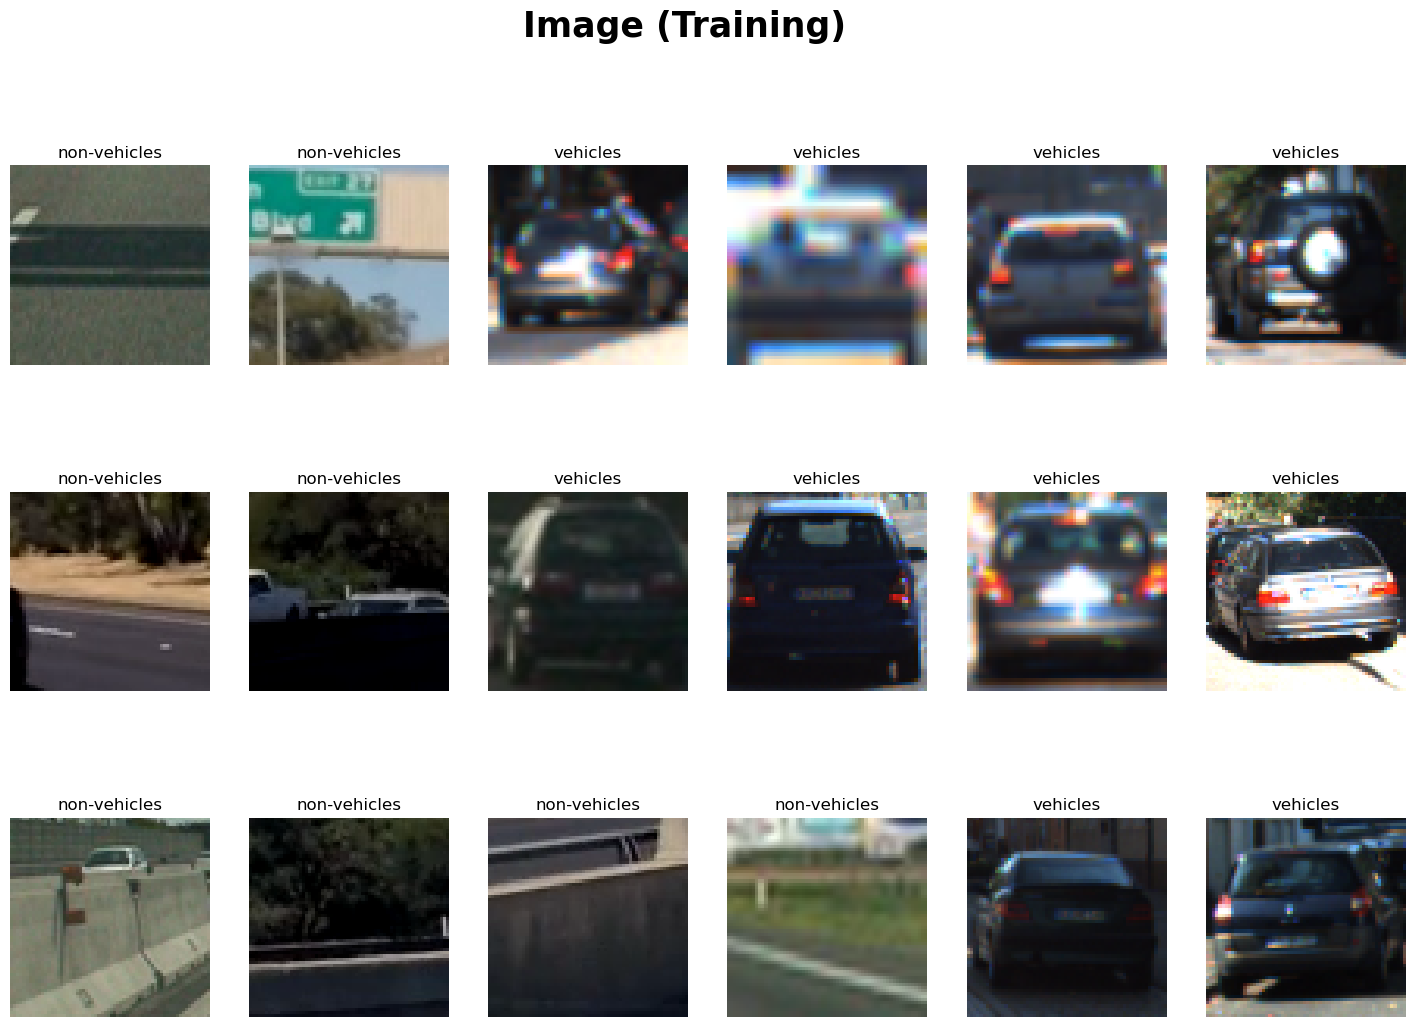

In [6]:
# Display image from Training dataset

n_images = 18
fig , axs = plt.subplots(figsize = (18,12))
fig.suptitle('Image (Training)', fontweight = 'bold' , fontsize = 25 , ha = 'center')
for img , label in train_set.take(1):
    for j in range(n_images):
        plt.subplot(3,6,j+1)
        plt.title(labels[np.argmax(label[j])])
        plt.imshow(img[j]/255.0)
        plt.axis('off')
    break
    

# Image Processing

In [7]:
# Split into TRAINING and TESTING (90-10)

import tensorflow as tf

DATASET_SIZE = len(list(train_set))
train_size = int(0.9 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size
dataset = train_set.shuffle(buffer_size=DATASET_SIZE)

train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)

In [8]:
# check For splitting
print(f'Training = {train_set.cardinality().numpy()}\nValidation = {val_set.cardinality().numpy()}\nTesting = {test_set.cardinality().numpy()}')

Training = 399
Validation = 111
Testing = 45


In [9]:
# Rescaling
def rescaling(image , label):
    return image/255.0 , label

In [10]:
train_set = train_set.map(rescaling)
val_set = val_set.map(rescaling)
test_set = test_set.map(rescaling)

In [11]:
# Augmenting
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image , max_delta = 0.5)
    return image ,label

In [12]:
train_set = train_set.map(augment_data)

In [13]:
# Prefetching
train_set = train_set.prefetch(tf.data.AUTOTUNE)
val_set = val_set.prefetch(tf.data.AUTOTUNE)
test_set = test_set.prefetch(tf.data.AUTOTUNE)

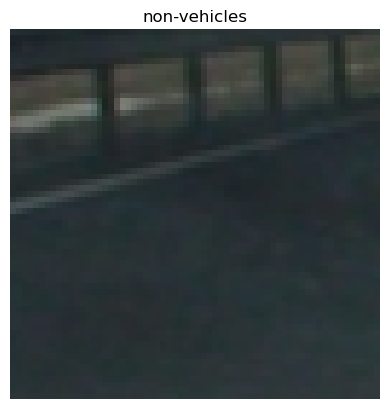

In [14]:
for img , label in test_set.take(3):
    plt.title(labels[np.argmax(label[10])])
    plt.imshow(img[10])
    plt.axis('off')
    break

# Modelling

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.001), 
                          activity_regularizer=regularizers.l1(0.001),
                          bias_regularizer=regularizers.l1(0.001)),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2340098 (8.93 MB)
Trainable params: 230598

# Training

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,        
    verbose=1,
    restore_best_weights=True
)

history = model.fit(train_set , validation_data = val_set , epochs = 10, 
          steps_per_epoch=train_set.cardinality().numpy(),
          validation_steps=val_set.cardinality().numpy())

Epoch 1/10
399/399 [==============================] - 102s 247ms/step - loss: 0.2947 - accuracy: 0.9452 - val_loss: 0.3394 - val_accuracy: 0.9631
Epoch 2/10
399/399 [==============================] - 220s 548ms/step - loss: 0.1821 - accuracy: 0.9846 - val_loss: 0.2442 - val_accuracy: 0.9755
Epoch 3/10
399/399 [==============================] - 199s 493ms/step - loss: 0.1574 - accuracy: 0.9890 - val_loss: 0.1719 - val_accuracy: 0.9854
Epoch 4/10
399/399 [==============================] - 186s 459ms/step - loss: 0.1338 - accuracy: 0.9933 - val_loss: 0.1333 - val_accuracy: 0.9935
Epoch 5/10
399/399 [==============================] - 181s 447ms/step - loss: 0.1187 - accuracy: 0.9948 - val_loss: 0.1475 - val_accuracy: 0.9879
Epoch 6/10
399/399 [==============================] - 182s 447ms/step - loss: 0.1071 - accuracy: 0.9955 - val_loss: 0.1226 - val_accuracy: 0.9901
Epoch 7/10
399/399 [==============================] - 175s 432ms/step - loss: 0.0951 - accuracy: 0.9964 - val_loss: 0.0857 -

# Evaluation

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_set)
print('\nTest accuracy:', test_acc)

45/45 [==============================] - 7s 109ms/step - loss: 0.0644 - accuracy: 0.9993

Test accuracy: 0.9993055462837219


# Training history

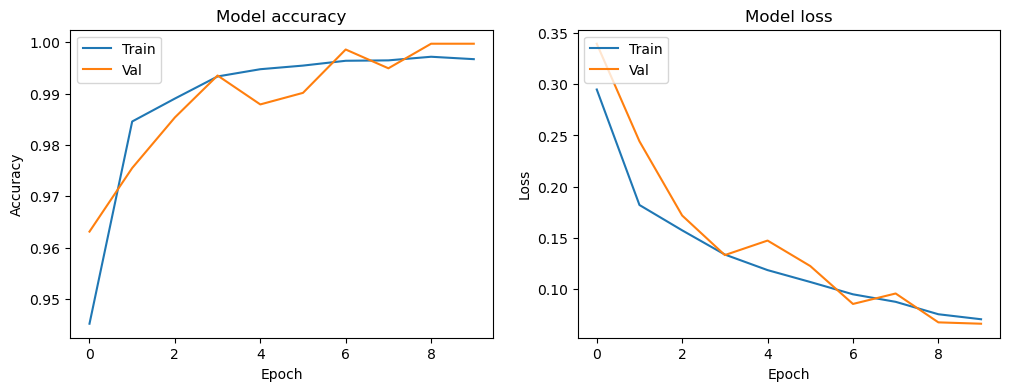

In [18]:
plt.figure(figsize=(12, 4))

# Plot training & validation ACCURACY values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation LOSS values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


# Prediction

In [19]:
predictions = model.predict(test_set)

# Convert probabilities to class labels
pred_classes = np.argmax(predictions, axis=1)

45/45 [==============================] - 7s 91ms/step


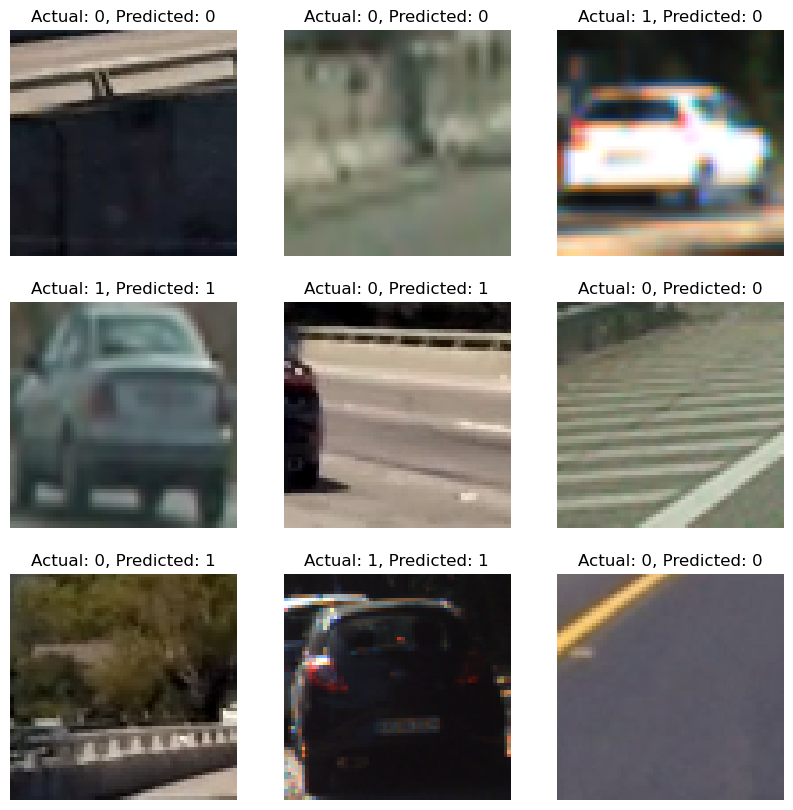

In [20]:
# Display prediction
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()

        # Check if the image is grayscale (single channel)
        if img.ndim == 2 or img.shape[2] == 1:
            #img = np.squeeze(img)
            cmap = 'gray'
        else:
            cmap = None

        # Rescale if the image is normalized
        if img.max() <= 1.0:  
            img = (img * 255).astype("uint8")

        plt.imshow(img, cmap=cmap)
        plt.title(f"Actual: {np.argmax(labels[i])}, Predicted: {pred_classes[i]}")
        plt.axis("off")



In [21]:
# Generate actual labels from the test set
actual_labels = np.concatenate([y for x, y in test_set], axis=0)
actual_classes = np.argmax(actual_labels, axis=1)
labels = ['non-vehicles', 'vehicles']
# Classification report
print(classification_report(actual_classes, pred_classes, target_names=labels))


              precision    recall  f1-score   support

non-vehicles       0.47      0.48      0.47       697
    vehicles       0.50      0.48      0.49       743

    accuracy                           0.48      1440
   macro avg       0.48      0.48      0.48      1440
weighted avg       0.48      0.48      0.48      1440



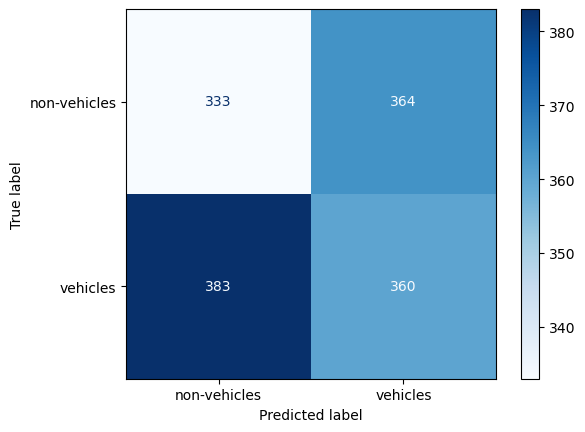

In [22]:
# Confusion Matrix
cm = confusion_matrix(actual_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
model.save('vehicle_classification_model_MBN.h5')

/Users/ngocle/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
import netron
from IPython.display import IFrame

# Start the Netron server
netron.start('vehicle_classification_model_MBN.h5', browse=False)

# Assuming Netron uses its default port (8080), display the model in the notebook
IFrame(src="http://localhost:8080", width="100%", height=500)


Serving 'vehicle_classification_model_MBN.h5' at http://localhost:8080


In [25]:
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Corrected import
import types

# Load your trained model (adjust the path to your model)
def custom_hasher(obj):
    return 0

@st.cache(allow_output_mutation=True, hash_funcs={types.FunctionType: custom_hasher})
def load_model():
    model = tf.keras.models.load_model('vehicle_classification_model_MBN.h5')
    return model

model = load_model()

st.title('Image Classification with MobileNetV2')

# Upload image interface
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png"])
if uploaded_file is not None:
    try:
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image', use_column_width=True)
        st.write("Processing the image...")

        # Preprocess the image to fit the model requirements
        def preprocess(image):
            image = image.resize((64, 64))  # MobileNetV2 expects image size of 224x224
            image = np.array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)  # Corrected function usage
            return image

        processed_image = preprocess(image)

        # Make prediction
        st.write("Making prediction...")
        predictions = model.predict(processed_image)

        # Post-process the predictions to display them
        # Adjust this according to your model's output
        st.write("Prediction: ", predictions)

    except Exception as e:
        st.error(f"An error occurred: {e}")


2023-11-17 16:48:06.961 
  command:

    streamlit run /Users/ngocle/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-11-17 16:48:08.427 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).


In [26]:
# http://localhost:8501/